In [1]:
from collections import defaultdict
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

In [2]:
root = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def balance_dataset(images, labels, random_state=42):
    labels = np.array(labels)
    indices = np.arange(len(labels))

    ros = RandomOverSampler(sampling_strategy="auto", random_state=random_state)
    balanced_indices, balanced_labels = ros.fit_resample(indices.reshape(-1, 1), labels)
    
    balanced_indices = balanced_indices.flatten()
    balanced_images = [images[i] for i in balanced_indices]
    balanced_labels = balanced_labels.tolist()
    
    return balanced_images, balanced_labels

In [4]:
class ImageDataset:
    def __init__(self, images, labels, classes, transform=None, batch_size=128):

        self.classes = classes
        self.transform = transform
        self.batch_size = batch_size

        self.images = [self.transform(image) for image in images]
        self.labels = labels
        
        self.X_train, self.X_val, self.X_test = None, None, None
        self.y_train, self.y_val, self.y_test = None, None, None
        self.train_loader, self.val_loader, self.test_loader = None, None, None

    def train_test_split(self, test_size=0.2, val_size=0.2, random_state=42):
        # Split the dataset
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            self.images, self.labels, test_size=test_size, random_state=random_state, stratify=self.labels
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=val_size, random_state=random_state, stratify=y_train_full
        )

        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

        self._print_class_distribution(self.y_train, "Training Set")
        self._print_class_distribution(self.y_val, "Validation Set")
        self._print_class_distribution(self.y_test, "Test Set")

    def prepare_loaders(self):
        train_dataset = TensorDataset(torch.stack(self.X_train).to(device), torch.tensor(self.y_train).to(device))
        val_dataset = TensorDataset(torch.stack(self.X_val).to(device), torch.tensor(self.y_val).to(device))
        test_dataset = TensorDataset(torch.stack(self.X_test).to(device), torch.tensor(self.y_test).to(device))

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

    def show_images_per_class(self, dataset=None, num_images=2):
        class_images = defaultdict(list)
        for img_tensor, label in zip(self.images, self.labels):
            if len(class_images[label]) < num_images:
                class_images[label].append(img_tensor)
            if len(class_images) == len(self.classes) and all(len(images) >= num_images for images in class_images.values()):
                break
    
        plt.figure(figsize=(12, len(class_images) * 3))
        for i, (label, images) in enumerate(class_images.items()):
            for j, img_tensor in enumerate(images):
                plt.subplot(len(class_images), num_images, i * num_images + j + 1)
                # Convert tensor to numpy for plotting
                plt.imshow(img_tensor.permute(1, 2, 0).numpy())
                plt.title(f"Class: {self.classes[label]}")
                plt.axis("off")
    
        plt.tight_layout()
        plt.show()

    def class_distribution(self):
        class_counts = defaultdict(int)
        for label in self.labels:
            class_counts[self.classes[label]] += 1

        plt.figure(figsize=(10, 5))
        plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
        plt.xlabel('Class')
        plt.ylabel('Number of Samples')
        plt.title('Class Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def analyze_image_colors(self):
        means, stds = [], []
        for img_tensor in self.images:
            if not isinstance(img_tensor, torch.Tensor):
                raise ValueError("Images should be stored as tensors in `self.images`.")
            means.append(img_tensor.mean(dim=(1, 2)))  # Compute mean per channel
            stds.append(img_tensor.std(dim=(1, 2)))   # Compute std dev per channel
    
        means = torch.stack(means).mean(dim=0)
        stds = torch.stack(stds).mean(dim=0)
    
        print(f"Dataset Mean Colors (R, G, B): {means.tolist()}")
        print(f"Dataset Std Dev Colors (R, G, B): {stds.tolist()}")

    def _print_class_distribution(self, labels, set_name):
        class_counts = defaultdict(int)
        for label in labels:
            class_counts[self.classes[label]] += 1
    
        print(f"{set_name}:")
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count}")

In [5]:
dataset = datasets.ImageFolder(root=root, transform=None)
original_images = [sample[0] for sample in dataset]
original_labels = [sample[1] for sample in dataset]
classes = dataset.classes

balanced_images, balanced_labels = balance_dataset(original_images, original_labels)

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

custom_dataset = ImageDataset(balanced_images, balanced_labels, classes, transform=transform, batch_size=128)

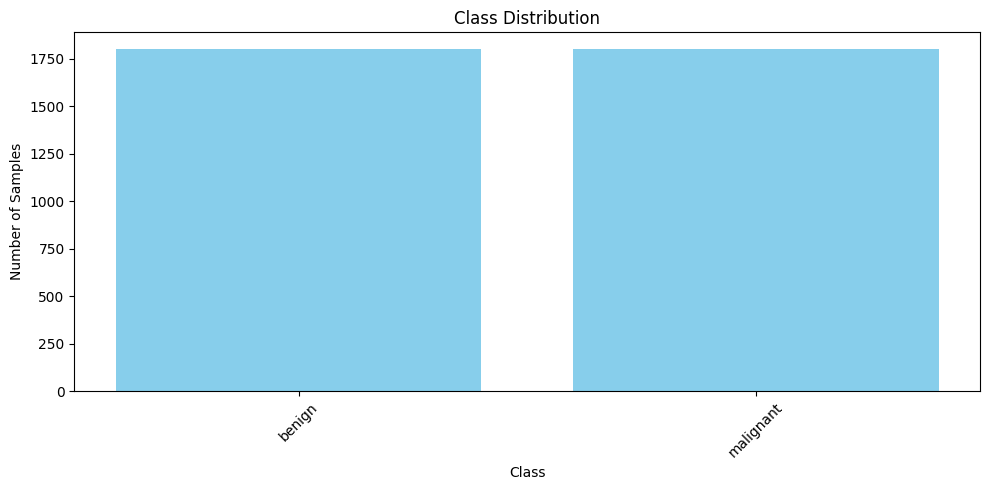

In [6]:
custom_dataset.class_distribution()

Dataset Mean Colors (R, G, B): [0.7114824652671814, 0.5081033110618591, 0.5074169039726257]
Dataset Std Dev Colors (R, G, B): [0.1777469366788864, 0.1571178138256073, 0.16608455777168274]


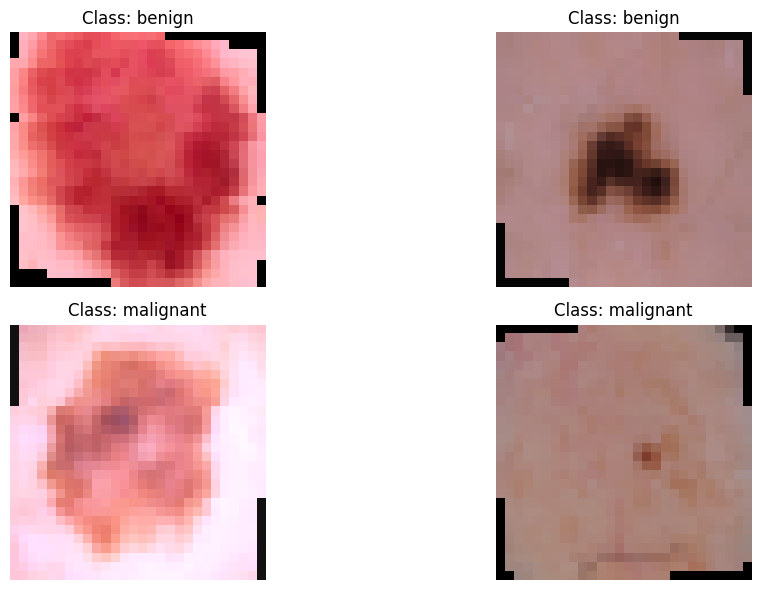

In [7]:
custom_dataset.analyze_image_colors()
custom_dataset.show_images_per_class()

In [8]:
custom_dataset.train_test_split()
custom_dataset.prepare_loaders()

Training Set:
  benign: 1152
  malignant: 1152
Validation Set:
  benign: 288
  malignant: 288
Test Set:
  malignant: 360
  benign: 360


In [9]:
class SkinCancerModelWithEarlyStopping:
    def __init__(self, model, device, verbose=True):
        self.model = model
        self.device = device
        self.verbose = verbose

    def train_epoch(self, loader, optimizer, criterion):
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in tqdm(loader, desc="Training Epoch", leave=False):
            images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        return epoch_loss, epoch_accuracy

    def evaluate(self, loader, criterion):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, dim=1)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
                
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
                predicted_probs.extend(probs.cpu().numpy())

        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        return avg_loss, accuracy, true_labels, predicted_labels, predicted_probs

    def train_model_early_stop(self, num_epochs, train_loader, valid_loader, optimizer, criterion, patience=5, min_delta=0):
        best_loss = float('inf')
        epochs_no_improve = 0
        best_model_weights = self.model.state_dict()
        loss_history, accuracy_history = [], []
        val_loss_history, val_accuracy_history = [], []

        for epoch in range(num_epochs):
            if self.verbose:
                print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, _, _, _ = self.evaluate(valid_loader, criterion)

            loss_history.append(train_loss)
            accuracy_history.append(train_acc)
            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_acc)

            if self.verbose:
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_loss < best_loss - min_delta:
                best_loss = val_loss
                epochs_no_improve = 0
                best_model_weights = self.model.state_dict()
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                if self.verbose:
                    print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        self.model.load_state_dict(best_model_weights)
        return loss_history, accuracy_history, val_loss_history, val_accuracy_history

    def evaluate_test_set(self, test_loader, criterion, class_names):
        if self.verbose:
            print("\nEvaluating on Test Set...")
        test_loss, test_acc, true_labels, predicted_labels, predicted_probs = self.evaluate(test_loader, criterion)
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        if self.verbose:
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names)))
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()
        
        return test_loss, test_acc, precision, recall, f1, true_labels, predicted_labels

    def plot_training_curves(self, train_loss, val_loss, train_acc, val_acc):
        epochs = len(train_loss)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_loss, label="Training Loss", color="blue")
        plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss", color="orange")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_acc, label="Training Accuracy", color="blue")
        plt.plot(range(1, epochs + 1), val_acc, label="Validation Accuracy", color="orange")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.show()


In [10]:
class SkinCancerClassifierCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SkinCancerClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.pool4 = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.fc1 = nn.Linear(128 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        x = x.view(-1, 128 * 2 * 2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
model = SkinCancerClassifierCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = SkinCancerModelWithEarlyStopping(model, device)

loss_hist, acc_hist, val_loss_hist, val_acc_hist = trainer.train_model_early_stop(
    num_epochs=50,
    train_loader=custom_dataset.train_loader,
    valid_loader=custom_dataset.val_loader,
    optimizer=optimizer,
    criterion=criterion,
    patience=10
)


Epoch [1/50]


Train Loss: 0.6916, Train Acc: 0.5169, Val Loss: 0.6810, Val Acc: 0.7461

Epoch [2/50]


Train Loss: 0.6247, Train Acc: 0.6710, Val Loss: 0.5320, Val Acc: 0.7480

Epoch [3/50]


Train Loss: 0.5567, Train Acc: 0.7170, Val Loss: 0.5366, Val Acc: 0.7383

Epoch [4/50]


Train Loss: 0.5281, Train Acc: 0.7491, Val Loss: 0.5478, Val Acc: 0.7324

Epoch [5/50]


Train Loss: 0.5100, Train Acc: 0.7595, Val Loss: 0.4570, Val Acc: 0.7930

Epoch [6/50]


Train Loss: 0.4816, Train Acc: 0.7656, Val Loss: 0.4579, Val Acc: 0.7852

Epoch [7/50]


Train Loss: 0.4800, Train Acc: 0.7743, Val Loss: 0.4445, Val Acc: 0.8008

Epoch [8/50]


Train Loss: 0.4542, Train Acc: 0.7817, Val Loss: 0.4322, Val Acc: 0.8027

Epoch [9/50]


Train Loss: 0.4446, Train Acc: 0.7804, Val Loss: 0.4367, Val Acc: 0.7949

Epoch [10/50]


Train Loss: 0.4377, Train Acc: 0.7869, Val Loss: 0.4240, Val Acc: 0.8008

Epoch [11/50]


Train Loss: 0.4250, Train Acc: 0.7878, Val Loss: 0.4300, Val Acc: 0.7910

Epoch [12/50]


Train Loss: 0.4264, Train Acc: 0.7895, Val Loss: 0.4208, Val Acc: 0.8105

Epoch [13/50]


Train Loss: 0.4213, Train Acc: 0.7960, Val Loss: 0.4684, Val Acc: 0.7891

Epoch [14/50]


Train Loss: 0.4301, Train Acc: 0.8003, Val Loss: 0.4108, Val Acc: 0.8223

Epoch [15/50]


Train Loss: 0.3990, Train Acc: 0.8069, Val Loss: 0.4210, Val Acc: 0.8066

Epoch [16/50]


Train Loss: 0.4039, Train Acc: 0.8060, Val Loss: 0.4495, Val Acc: 0.8027

Epoch [17/50]


Train Loss: 0.3844, Train Acc: 0.8190, Val Loss: 0.3979, Val Acc: 0.8301

Epoch [18/50]


Train Loss: 0.3831, Train Acc: 0.8086, Val Loss: 0.4115, Val Acc: 0.8164

Epoch [19/50]


Train Loss: 0.3907, Train Acc: 0.8125, Val Loss: 0.4219, Val Acc: 0.8242

Epoch [20/50]


Train Loss: 0.3971, Train Acc: 0.8225, Val Loss: 0.3827, Val Acc: 0.8301

Epoch [21/50]


Train Loss: 0.4060, Train Acc: 0.8064, Val Loss: 0.4004, Val Acc: 0.8105

Epoch [22/50]


Train Loss: 0.3882, Train Acc: 0.8142, Val Loss: 0.3951, Val Acc: 0.8027

Epoch [23/50]


Train Loss: 0.3698, Train Acc: 0.8264, Val Loss: 0.3591, Val Acc: 0.8340

Epoch [24/50]


Train Loss: 0.3692, Train Acc: 0.8203, Val Loss: 0.4560, Val Acc: 0.7891

Epoch [25/50]


Train Loss: 0.3852, Train Acc: 0.8160, Val Loss: 0.4412, Val Acc: 0.7891

Epoch [26/50]


Train Loss: 0.3715, Train Acc: 0.8203, Val Loss: 0.3726, Val Acc: 0.8301

Epoch [27/50]


Train Loss: 0.3420, Train Acc: 0.8403, Val Loss: 0.3606, Val Acc: 0.8301

Epoch [28/50]


Train Loss: 0.3586, Train Acc: 0.8268, Val Loss: 0.3589, Val Acc: 0.8281

Epoch [29/50]


Train Loss: 0.3260, Train Acc: 0.8481, Val Loss: 0.3446, Val Acc: 0.8477

Epoch [30/50]


Train Loss: 0.3134, Train Acc: 0.8542, Val Loss: 0.3478, Val Acc: 0.8477

Epoch [31/50]


Train Loss: 0.3134, Train Acc: 0.8529, Val Loss: 0.3477, Val Acc: 0.8574

Epoch [32/50]


Train Loss: 0.3234, Train Acc: 0.8446, Val Loss: 0.3349, Val Acc: 0.8574

Epoch [33/50]


Train Loss: 0.2800, Train Acc: 0.8785, Val Loss: 0.3273, Val Acc: 0.8594

Epoch [34/50]


Train Loss: 0.2786, Train Acc: 0.8789, Val Loss: 0.4189, Val Acc: 0.8438

Epoch [35/50]


Train Loss: 0.2942, Train Acc: 0.8711, Val Loss: 0.3281, Val Acc: 0.8574

Epoch [36/50]


Train Loss: 0.2911, Train Acc: 0.8663, Val Loss: 0.3239, Val Acc: 0.8613

Epoch [37/50]


Train Loss: 0.2630, Train Acc: 0.8841, Val Loss: 0.3797, Val Acc: 0.8340

Epoch [38/50]


Train Loss: 0.2524, Train Acc: 0.8876, Val Loss: 0.3225, Val Acc: 0.8613

Epoch [39/50]


Train Loss: 0.2392, Train Acc: 0.8945, Val Loss: 0.3415, Val Acc: 0.8477

Epoch [40/50]


Train Loss: 0.2472, Train Acc: 0.8976, Val Loss: 0.3829, Val Acc: 0.8242

Epoch [41/50]


Train Loss: 0.2327, Train Acc: 0.9045, Val Loss: 0.3569, Val Acc: 0.8535

Epoch [42/50]


Train Loss: 0.2245, Train Acc: 0.8997, Val Loss: 0.3563, Val Acc: 0.8652

Epoch [43/50]


Train Loss: 0.2169, Train Acc: 0.9102, Val Loss: 0.4009, Val Acc: 0.8438

Epoch [44/50]


Train Loss: 0.2157, Train Acc: 0.9045, Val Loss: 0.3577, Val Acc: 0.8516

Epoch [45/50]


Train Loss: 0.2149, Train Acc: 0.9067, Val Loss: 0.4022, Val Acc: 0.8105

Epoch [46/50]


Train Loss: 0.2034, Train Acc: 0.9154, Val Loss: 0.3552, Val Acc: 0.8496

Epoch [47/50]


Train Loss: 0.1885, Train Acc: 0.9162, Val Loss: 0.4200, Val Acc: 0.8438

Epoch [48/50]


Train Loss: 0.1689, Train Acc: 0.9288, Val Loss: 0.3970, Val Acc: 0.8379
Early stopping triggered after 48 epochs.


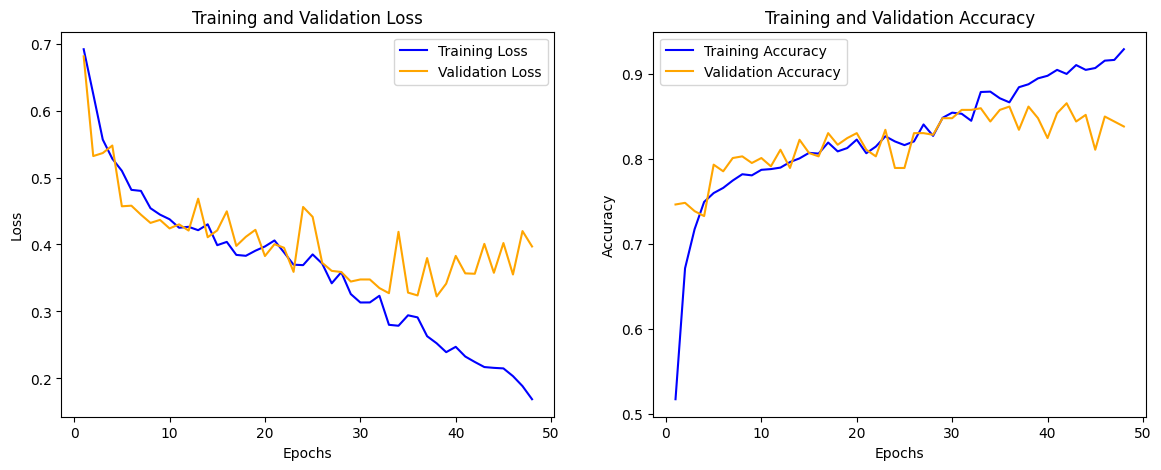


Evaluating on Test Set...
Test Loss: 0.5096, Test Accuracy: 0.8156
Precision: 0.8248, Recall: 0.8043, F1 Score: 0.8145


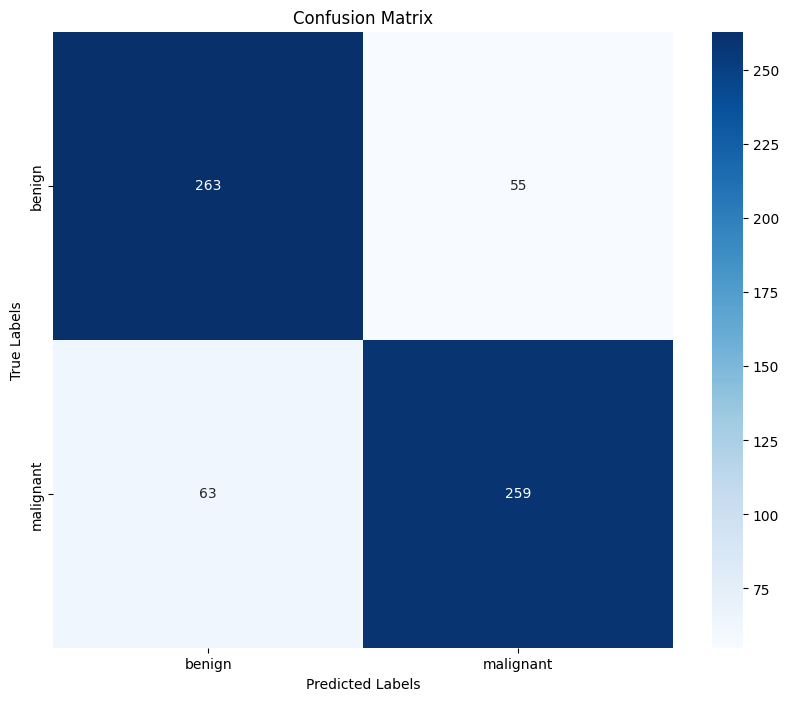

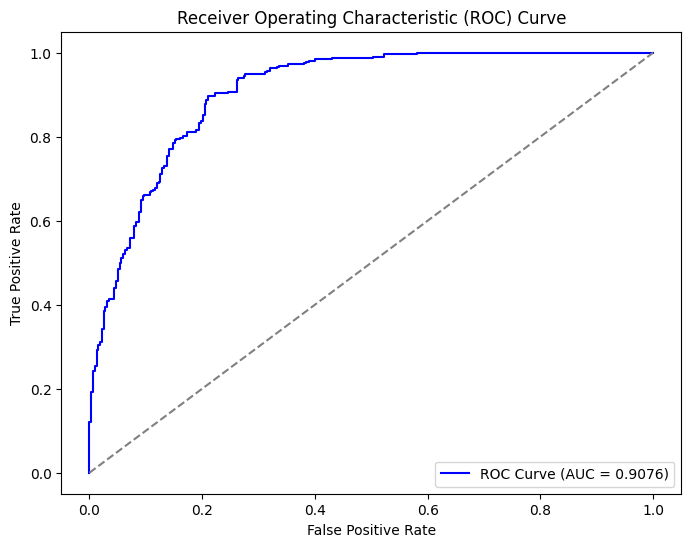

In [12]:
trainer.plot_training_curves(loss_hist, val_loss_hist, acc_hist, val_acc_hist)
test_loss, test_acc, precision, recall, f1, true_labels, predicted_labels = trainer.evaluate_test_set(custom_dataset.test_loader, criterion, custom_dataset.classes)

In [13]:
class ImprovedSkinCancerClassifierCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedSkinCancerClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)
        
        self.fc1 = nn.Linear(2 * 2 * 128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, num_classes)

        self.dropout_fc = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 128 * 2 * 2)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        # x = F.relu(self.fc2(x))
        # x = self.dropout_fc(x)

        x = F.relu(self.fc3(x))
        x = self.dropout_fc(x)
        
        x = self.fc4(x)

        return x

In [14]:
model = ImprovedSkinCancerClassifierCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = SkinCancerModelWithEarlyStopping(model, device)

loss_hist, acc_hist, val_loss_hist, val_acc_hist = trainer.train_model_early_stop(
    num_epochs=50,
    train_loader=custom_dataset.train_loader,
    valid_loader=custom_dataset.val_loader,
    optimizer=optimizer,
    criterion=criterion,
    patience=10
)


Epoch [1/50]


Train Loss: 0.5645, Train Acc: 0.6931, Val Loss: 0.6483, Val Acc: 0.5312

Epoch [2/50]


Train Loss: 0.4484, Train Acc: 0.7895, Val Loss: 0.4148, Val Acc: 0.7969

Epoch [3/50]


Train Loss: 0.4073, Train Acc: 0.8095, Val Loss: 0.6291, Val Acc: 0.7324

Epoch [4/50]


Train Loss: 0.3975, Train Acc: 0.8099, Val Loss: 0.3968, Val Acc: 0.8008

Epoch [5/50]


Train Loss: 0.3639, Train Acc: 0.8333, Val Loss: 0.4343, Val Acc: 0.7832

Epoch [6/50]


Train Loss: 0.3384, Train Acc: 0.8446, Val Loss: 0.4555, Val Acc: 0.8008

Epoch [7/50]


Train Loss: 0.3083, Train Acc: 0.8589, Val Loss: 0.4580, Val Acc: 0.8164

Epoch [8/50]


Train Loss: 0.2902, Train Acc: 0.8607, Val Loss: 0.5391, Val Acc: 0.7617

Epoch [9/50]


Train Loss: 0.2974, Train Acc: 0.8694, Val Loss: 0.3701, Val Acc: 0.8398

Epoch [10/50]


Train Loss: 0.3098, Train Acc: 0.8550, Val Loss: 0.3890, Val Acc: 0.8145

Epoch [11/50]


Train Loss: 0.2545, Train Acc: 0.8885, Val Loss: 0.3870, Val Acc: 0.8145

Epoch [12/50]


Train Loss: 0.2835, Train Acc: 0.8698, Val Loss: 0.4016, Val Acc: 0.8047

Epoch [13/50]


Train Loss: 0.2497, Train Acc: 0.8911, Val Loss: 0.5461, Val Acc: 0.7988

Epoch [14/50]


Train Loss: 0.1923, Train Acc: 0.9154, Val Loss: 0.4061, Val Acc: 0.8418

Epoch [15/50]


Train Loss: 0.2120, Train Acc: 0.9049, Val Loss: 0.6561, Val Acc: 0.7871

Epoch [16/50]


Train Loss: 0.1529, Train Acc: 0.9375, Val Loss: 0.5297, Val Acc: 0.8359

Epoch [17/50]


Train Loss: 0.1561, Train Acc: 0.9388, Val Loss: 0.9000, Val Acc: 0.7559

Epoch [18/50]


Train Loss: 0.2360, Train Acc: 0.8950, Val Loss: 0.4138, Val Acc: 0.8262

Epoch [19/50]


Train Loss: 0.1513, Train Acc: 0.9375, Val Loss: 0.5766, Val Acc: 0.8262
Early stopping triggered after 19 epochs.


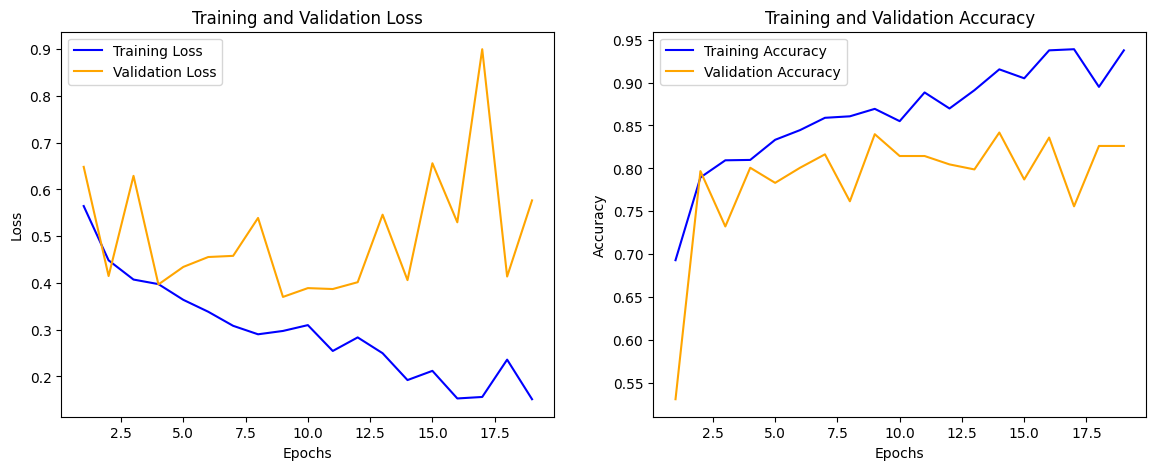


Evaluating on Test Set...
Test Loss: 0.6087, Test Accuracy: 0.8375
Precision: 0.7725, Recall: 0.9596, F1 Score: 0.8560


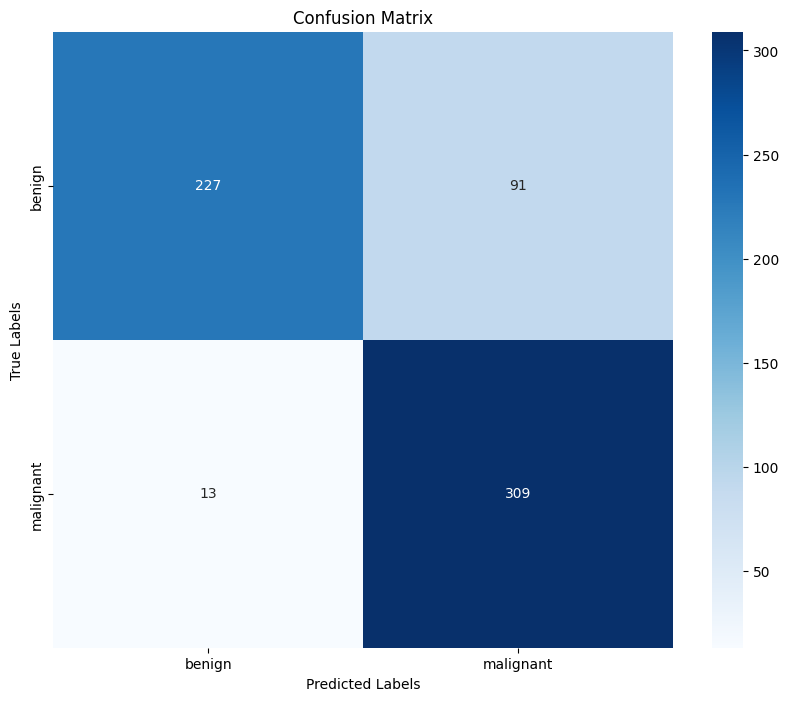

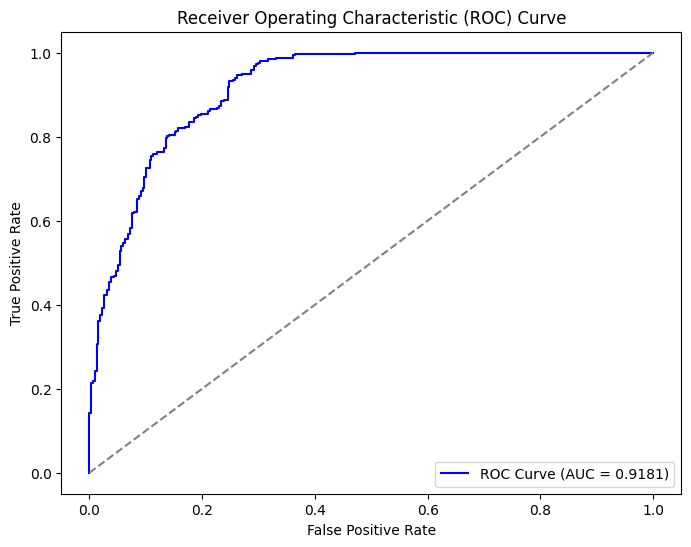

In [15]:
trainer.plot_training_curves(loss_hist, val_loss_hist, acc_hist, val_acc_hist)
test_loss, test_acc, precision, recall, f1, true_labels, predicted_labels = trainer.evaluate_test_set(custom_dataset.test_loader, criterion, custom_dataset.classes)

In [16]:
dataset = datasets.ImageFolder(root=root, transform=None)
original_images = [sample[0] for sample in dataset]
original_labels = [sample[1] for sample in dataset]
classes = dataset.classes

balanced_images, balanced_labels = balance_dataset(original_images, original_labels)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

custom_dataset_resnet = ImageDataset(balanced_images, balanced_labels, classes, transform=transform, batch_size=128)

In [17]:
custom_dataset_resnet.train_test_split()
custom_dataset_resnet.prepare_loaders()

Training Set:
  benign: 1152
  malignant: 1152
Validation Set:
  benign: 288
  malignant: 288
Test Set:
  malignant: 360
  benign: 360


In [18]:
model = model = models.resnet18(pretrained=True).to(device)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = SkinCancerModelWithEarlyStopping(model, device, verbose=True)

num_epochs = 50
patience = 10
min_delta = 0.01

loss_history, accuracy_history, val_loss_history, val_accuracy_history = trainer.train_model_early_stop(
    num_epochs=num_epochs,
    train_loader=custom_dataset_resnet.train_loader,
    valid_loader=custom_dataset_resnet.val_loader,
    optimizer=optimizer,
    criterion=criterion,
    patience=patience,
    min_delta=min_delta
)


Epoch [1/50]


Train Loss: 0.5507, Train Acc: 0.7209, Val Loss: 0.5515, Val Acc: 0.7402

Epoch [2/50]


Train Loss: 0.4278, Train Acc: 0.8095, Val Loss: 0.4183, Val Acc: 0.8164

Epoch [3/50]


Train Loss: 0.4117, Train Acc: 0.8155, Val Loss: 0.4162, Val Acc: 0.8145

Epoch [4/50]


Train Loss: 0.4151, Train Acc: 0.8129, Val Loss: 0.3817, Val Acc: 0.8340

Epoch [5/50]


Train Loss: 0.4035, Train Acc: 0.8155, Val Loss: 0.3670, Val Acc: 0.8398

Epoch [6/50]


Train Loss: 0.3712, Train Acc: 0.8359, Val Loss: 0.3671, Val Acc: 0.8359

Epoch [7/50]


Train Loss: 0.3671, Train Acc: 0.8325, Val Loss: 0.3621, Val Acc: 0.8418

Epoch [8/50]


Train Loss: 0.3597, Train Acc: 0.8407, Val Loss: 0.3584, Val Acc: 0.8418

Epoch [9/50]


Train Loss: 0.3615, Train Acc: 0.8394, Val Loss: 0.3667, Val Acc: 0.8477

Epoch [10/50]


Train Loss: 0.3567, Train Acc: 0.8385, Val Loss: 0.3936, Val Acc: 0.8281

Epoch [11/50]


Train Loss: 0.3897, Train Acc: 0.8286, Val Loss: 0.3744, Val Acc: 0.8379

Epoch [12/50]


Train Loss: 0.3528, Train Acc: 0.8468, Val Loss: 0.3514, Val Acc: 0.8438

Epoch [13/50]


Train Loss: 0.3557, Train Acc: 0.8364, Val Loss: 0.3498, Val Acc: 0.8438

Epoch [14/50]


Train Loss: 0.3412, Train Acc: 0.8481, Val Loss: 0.3513, Val Acc: 0.8477

Epoch [15/50]


Train Loss: 0.3401, Train Acc: 0.8442, Val Loss: 0.3526, Val Acc: 0.8477

Epoch [16/50]


Train Loss: 0.3388, Train Acc: 0.8529, Val Loss: 0.3470, Val Acc: 0.8496

Epoch [17/50]


Train Loss: 0.3365, Train Acc: 0.8542, Val Loss: 0.3459, Val Acc: 0.8496

Epoch [18/50]


Train Loss: 0.3316, Train Acc: 0.8537, Val Loss: 0.3441, Val Acc: 0.8457

Epoch [19/50]


Train Loss: 0.3310, Train Acc: 0.8516, Val Loss: 0.3450, Val Acc: 0.8457

Epoch [20/50]


Train Loss: 0.3274, Train Acc: 0.8615, Val Loss: 0.3430, Val Acc: 0.8496

Epoch [21/50]


Train Loss: 0.3224, Train Acc: 0.8607, Val Loss: 0.3460, Val Acc: 0.8496

Epoch [22/50]


Train Loss: 0.3236, Train Acc: 0.8546, Val Loss: 0.3425, Val Acc: 0.8477
Early stopping triggered after 22 epochs.


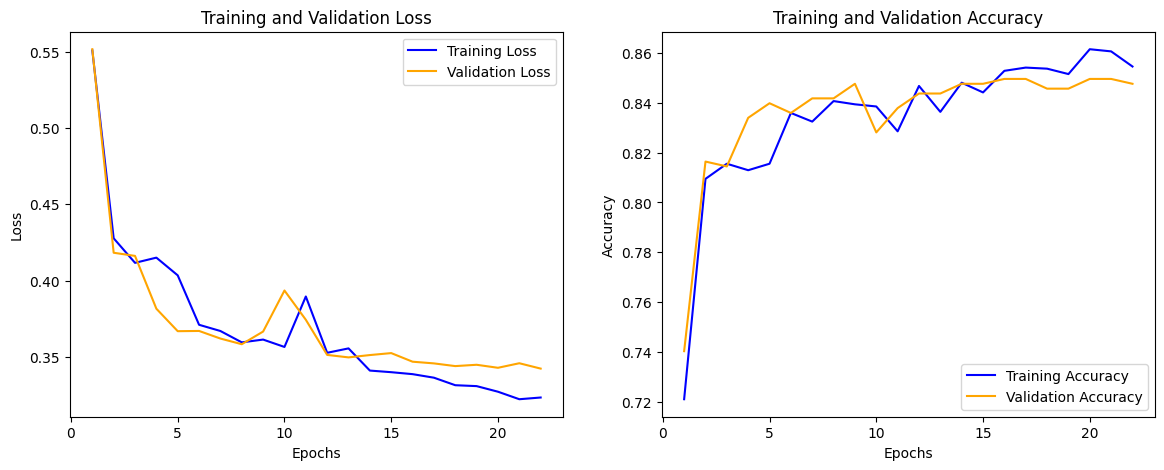


Evaluating on Test Set...
Test Loss: 0.3362, Test Accuracy: 0.8500
Precision: 0.8404, Recall: 0.8665, F1 Score: 0.8532


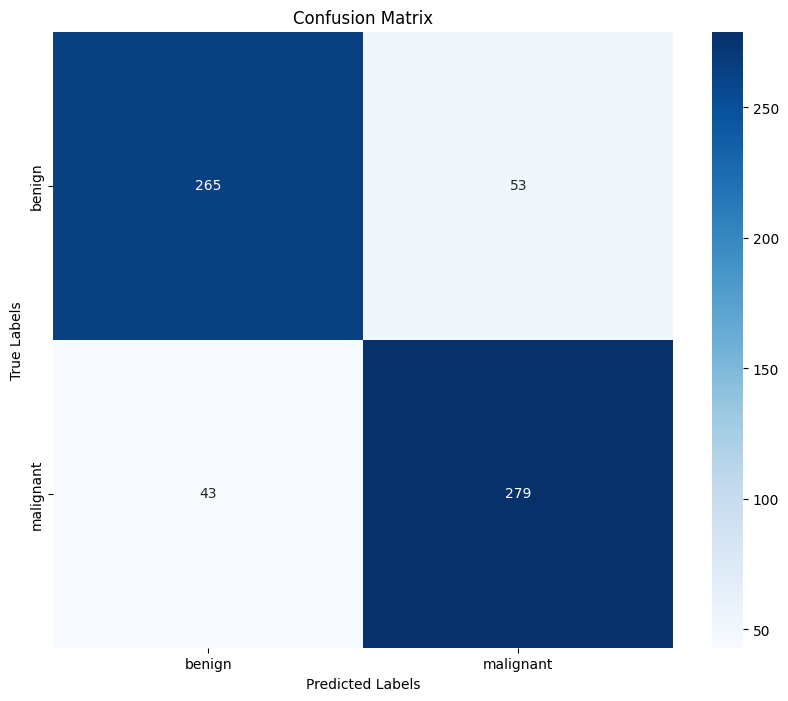

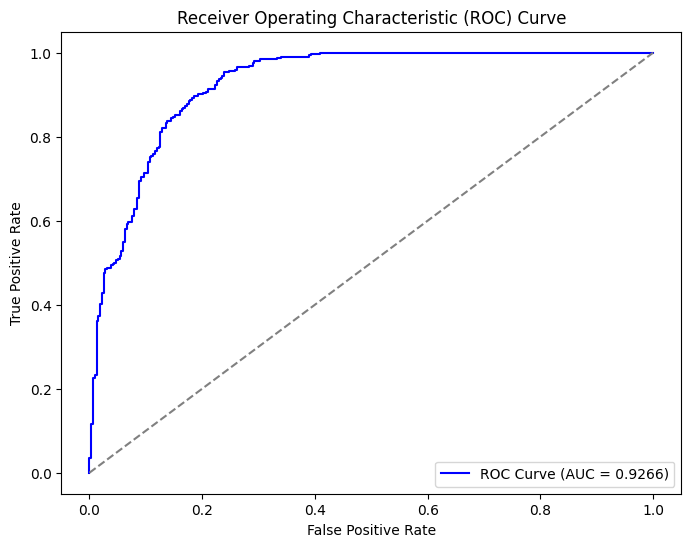

In [20]:
trainer.plot_training_curves(loss_history, val_loss_history, accuracy_history, val_accuracy_history)
test_loss, test_acc, precision, recall, f1, true_labels, predicted_labels = trainer.evaluate_test_set(custom_dataset_resnet.test_loader, criterion, custom_dataset_resnet.classes)